# Natural Convection with SpatialPy

## Definition of the model

### Imports and definitions

In [1]:
import os
import sys
import math
sys.path.insert(1, "../..")
import numpy as np
import matplotlib.pyplot as plt

import spatialpy

In [2]:
class Cylinder(spatialpy.Geometry):
    def __init__(self, radius):
        self.radius = radius
    
    def inside(self, x, on_boundary):
        return x[0]**2 + x[1]**2 < self.radius**2

In [3]:
class Walls(spatialpy.Geometry):
    def __init__(self, minint, maxint):
        self.min = minint
        self.max = maxint
    
    def inside(self, x, on_boundary):
        # Bottom Wall
        if x[1] <= self.min: return True
        # Top Wall
        if x[1] >= self.max: return True
        # Left Wall
        if x[0] <= self.min: return True
        # Right Wall
        if x[0] >= self.max: return True
        return False

In [4]:
class BouyancyForce(spatialpy.BoundaryCondition):
    def __init__(self, type_id, acceleration, C_ref):
        self.type_id = type_id
        self.acceleration = acceleration
        self.C_ref = C_ref
        
    def expression(self):
        bc_str = f"if(me->type == {self.type_id})" + "{"
        bc_str += f"me->F[1] += me->mass * {self.acceleration} * (me->C[0] - {self.C_ref});"
        bc_str += "}"
        return bc_str

### Model

In [57]:
class NaturalConvection(spatialpy.Model):
    FLUID = 1
    WALLS = 2
    CYLINDER = 3

    def __init__(self, model_name="Natural Convection", Ra=1e4):
        spatialpy.Model.__init__(self, model_name)
        
        # System Constants
        Sc = 0.7 # Schmidt Number
        kappastar = 1/math.sqrt(Sc*Ra)
        Lint = 1
        Nint = 200
        Nwall = 3
        mustar = math.sqrt(Sc/Ra)
        rho0 = 1
        c0 = 5
        radius_external = 0.1
        gravity = [0, -1, 0]
        C0 = 1.0
        g = -1
        Cref = 0.0
        
        # Species
        A = spatialpy.Species(name="A", diffusion_coefficient=kappastar)
        print(f"species A: diffusion_coefficient={kappastar}")
        self.add_species(A)
        
        # Discretization
        Npx = Npy = Nint+2*Nwall
        Np = Npx*Npy
        
        # Compute domain bounds (including the boundary)
        delta = Lint/Nint
        L = Lint+Nwall*2*delta
        xmin = ymin = -L/2
        xmax = ymax = L/2
        minint = -Lint/2
        maxint = Lint/2
        
        # Compute volume and mass per particle
        vtot = L**2
        mi = vtot/Np # mass per particle
        
        # Domain
        e = 1e-6
        h = hc = 2.5*delta
        
        ###################################################
        # g = -1                                          #
        # Cref = 0.0                                      #
        #                                                 #
        # P0 = rho0 * v0**2                               #
        #    = rho0 * math.sqrt(g * beta * L *deltaC)**2  #
        #    = rho0 * g * beta * L * deltaC               #
        #    = rho0 * g * beta * L * (C - Cref)           #
        #                                                 #
        # From Paper                                      #
        # ----------                                      #
        # Fb = g * beta * deltaC * y                      #
        #    = g * beta * (C - Cref) * y                  #
        #                                                 #
        # From lammps                                     #
        # -----------                                     #
        # Fb = mass * g * deltaC                          #
        #    = mass * g * (C - Cref)                      #
        ###################################################
        
        domain = spatialpy.Domain.create_2D_domain(
            xlim=(xmin, xmax), ylim=(ymin, ymax), nx=Npx, ny=Npy, type_id=self.FLUID,
            mass=mi, nu=mustar, rho0=rho0, c0=c0, gravity=gravity, fixed=False
        )
        domain.dimensions = 2
        self.add_domain(domain)
        
        # Types
        self.set_type(Walls(minint, maxint), self.WALLS, fixed=True)
        self.set_type(Cylinder(radius_external), self.CYLINDER, fixed=True)
        
        # Static Domain
        self.staticDomain = False #not in self.domain.fixed
        
        # Initial Conditions
        uniform_ic = spatialpy.UniformInitialCondition(A, C0, [self.CYLINDER])
        self.add_initial_condition(uniform_ic)
        #print(f"C0={C0}")
        
        # Boundary Conditions
        walls_bc = spatialpy.BoundaryCondition(type_id=self.WALLS, species="A", value=0, model=self)
        self.add_boundary_condition(walls_bc)
        
        cylinder_bc = spatialpy.BoundaryCondition(type_id=self.CYLINDER, species="A", value=C0, model=self)
        self.add_boundary_condition(cylinder_bc)
        
        # Buoyancy Force
        Fb = BouyancyForce(type_id=self.FLUID, acceleration=g, C_ref=Cref)
        self.add_boundary_condition(Fb)

        
        # Timespan
        dt = 1e-4
        #nt = 10000000
        #nt = 100000
        #freq_results = nt/10000
        #self.timespan(np.arange(0, nt*dt+dt, freq_results*dt), timestep_size=dt)
        #print(f"tspan: np.arange(0, {nt*dt+dt}, {freq_results*dt}), timestep_size: {dt}")
        #self.domain.plot_types()
        #self.set_timesteps(output_interval=dt*freq_results, num_steps=int(nt/freq_results), timestep_size=dt)
        
        self.timespan(np.linspace(0, 5, 11), timestep_size=dt)
        
        # disable RDME simulation (not needed for heat transfer applications)
        self.enable_rdme = False
        

In [58]:
model = NaturalConvection()

species A: diffusion_coefficient=0.011952286093343936


In [59]:
solver = spatialpy.Solver(model=model, debug_level=0)
%time solver.compile()
solver.build_dir

CPU times: user 6.3 s, sys: 15.2 ms, total: 6.31 s
Wall time: 28 s


'/tmp/spatialpy_build_nbb3a_s7'

In [60]:
%time results = solver.run()

CPU times: user 627 ms, sys: 50.3 ms, total: 678 ms
Wall time: 7h 36min 48s


In [61]:
#results.plot_property("v", p_ndx=1, t_ndx=-1, use_matplotlib=False)

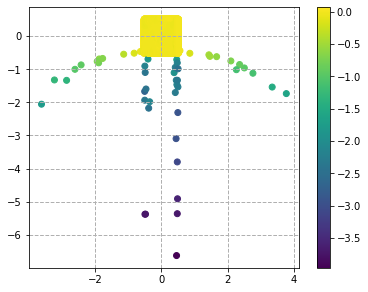

In [62]:
results.plot_property("v", p_ndx=1, t_ndx=-1, use_matplotlib=True)

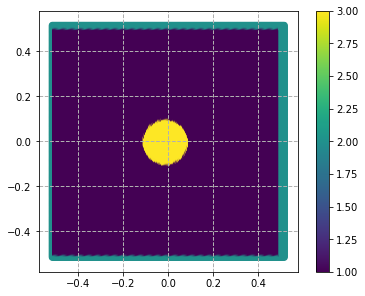

In [63]:
results.plot_property("type", use_matplotlib=True)

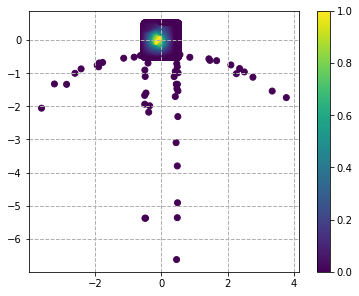

In [64]:
results.plot_species('A',t_ndx=-1,deterministic=True,use_matplotlib=True)

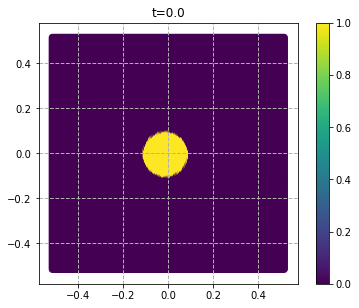

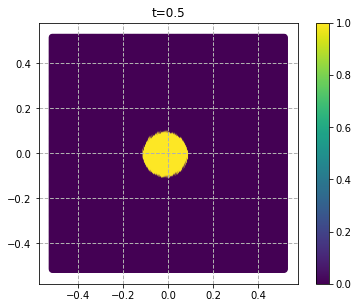

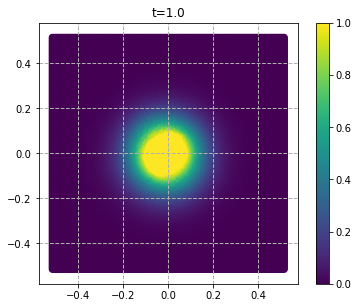

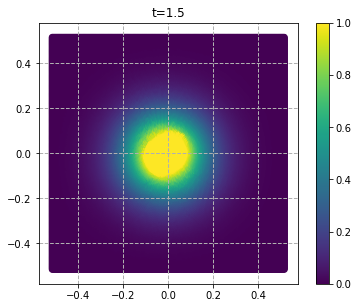

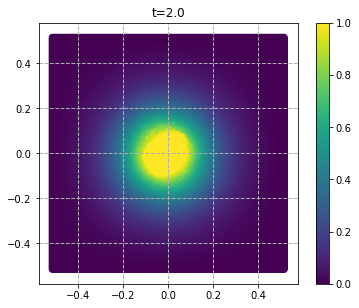

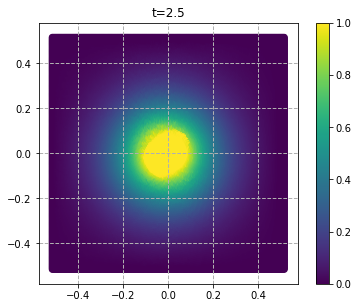

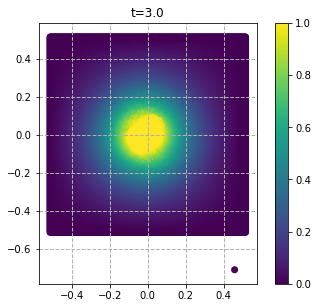

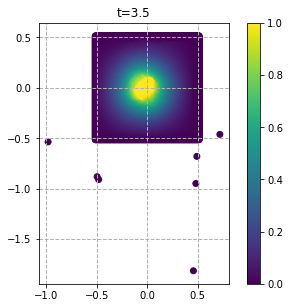

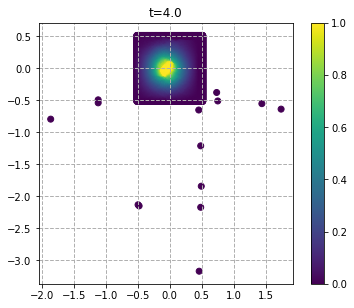

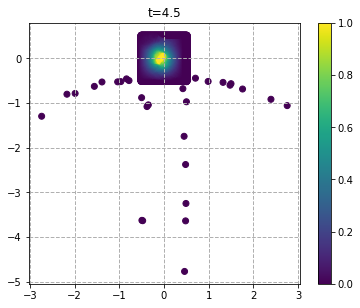

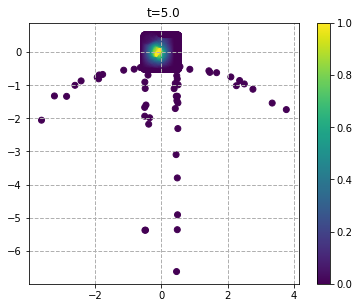

In [65]:
for n,t in enumerate(results.get_timespan()):
    results.plot_species('A',t_ndx=n,deterministic=True,use_matplotlib=True)
    plt.title(f"t={t}")